## Neural Networks for Classification of Emotions

- CNN을 통해 사람의 얼굴의 특징을 추출하고 예측하여 현재 사람의 감정을 추측 할 수 있다.
- 감정 종류: 분노, 기쁨, 분노, 공포, 기본
- 활용 분야: AI비서, 거짓말 탐지, 졸음운전 방지, 온라인 강의 관심도 체크 등등


In [2]:
import cv2
import numpy as np
import os
import zipfile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow .keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns # 데이터 시각화
import matplotlib.pyplot as plt # 그래프 생성
tf.__version__

'2.15.0'

### Loading the Images
- zip 파일 내부 구조 살펴보기
  - fer2013
    - trian: 학습 이미지
    - validation: 검증 이미지
    - README : 안내서
    - fer2013.bib : 데이터 셋의 작가, 정보, 출처 등
    - fer2013.csv: 학습 이미지를 이용하여 추출한 특징들을 따로 csv로 저장해둠 -> 굳이 처음부터 이미지를 학습 시킬 필요는 없음

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file= path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

### Train and test set 불러오기

In [5]:
training_generator = ImageDataGenerator(rescale= 1./255,
                                        rotation_range=7,
                                        horizontal_flip =True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/fer2013/train',
                                                       target_size = (48, 48),
                                                       batch_size = 16,
                                                       class_mode ='categorical',
                                                       shuffle = True)

Found 28709 images belonging to 7 classes.


In [6]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
# retrun_counts = true이면 각각의 도메인 값의 개수도 알려준다.
np.unique(train_dataset.classes,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [ ]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

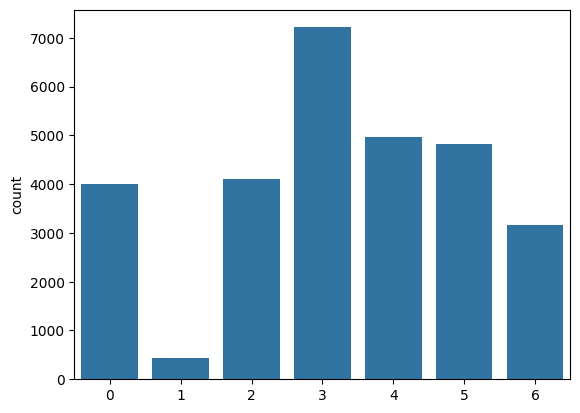

In [ ]:
sns.countplot(x=train_dataset.classes);

In [7]:
test_generator = ImageDataGenerator(1./255)
test_dataset = test_generator.flow_from_directory('/content/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size =1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


### 신경망 모델 구축

In [ ]:
num_detectors = 32
num_classes = 7
# 학습에 사용될 이미지 크기(48,48,3) 흑백 이미지인데도 채널이 3개인 이유는 3개다 동일한 값을 갖기때문이다.
width, height =48,48
epochs = 100

network = Sequential()

#커널의 수는 num_detectors개 필터 size는 (3,3)
#padding은 same과 valid가 있다
# same은 윈도우 슬라이딩을 하다가 만약 남은 원본이미지의 크기가 필터보다 작다면 0픽셀을 추가하여 합성곱을 하는것이다.
# valid는 초과되는 픽셀은 그냥 버린다 -> 특성이 버려진다.
network.add(Conv2D(num_detectors,(3,3),activation='relu',padding ='same',input_shape = (width, height, 3)))
# 배치 정규화는 각각의 배치들을 한번에 학습시킬때도 배치들 마다 크기가 달라서 학습률도 달라진다.
# 따라서 정규화를 통해 배치들간의 크기를 상대적으로 변환하여 학습을 유리하게 할 수 있다.
network.add(BatchNormalization())
network.add(Conv2D(num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))


network.add(Conv2D(2*num_detectors,(3,3),activation='relu',padding ='same'))
# 배치 정규화는 복잡한 이미지에 적합하다.
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))


network.add(Conv2D(2*2*num_detectors,(3,3),activation='relu',padding ='same'))
# 배치 정규화는 복잡한 이미지에 적합하다.
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))


network.add(Conv2D(2*2*2*num_detectors,(3,3),activation='relu',padding ='same'))
# 배치 정규화는 복잡한 이미지에 적합하다.
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors,(3,3),activation='relu',padding ='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

# flatten으로 필터의 가로크기 * 세로크기 * 커널의 수하면 평탄화 후 출력되는 크기가 나온다.
network.add(Flatten())

network.add(Dense(2*num_detectors, activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

# 무조건 은닉층의 개수 구하는 공식을 쓰는것이아니라 최적의 수를 찾아야한다.
network.add(Dense(2*num_detectors, activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation = 'softmax'))
network.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_28 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_29 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                      

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network.fit(train_dataset, epochs=epochs)

Epoch 1/100


KeyboardInterrupt: 

### 신경망 저장 및 불러오기
- 학습이 오래걸리기 때문에 이전에 학습된 가중치 파일을 사용한다.

In [ ]:
# 신경망 구조 저장
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
# 가중치 저장
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [8]:
# 신경망 구조 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [9]:
# 신경망 가중치 불러오기 및 compile설정
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/weights_emotions.hdf5')
network_loaded.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [8]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

### 신경망 평가

In [27]:
# evaluate(test 데이터)는 정확도 평가를 한번에 해주는 함수이다.
# 정확도가 0.58로 생각 보다 낮은데 애초에 감정을 찾는 인공지능은 최신기술로해도 70%정도의 확률로 어려운 주제이기 때문이다.
network_loaded.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


3589/3589 [==============================] - 74s 20ms/step - loss: 257.3426 - accuracy: 0.1513


[257.3425598144531, 0.15129563212394714]

In [1]:
predictions = network_loaded.predict(test_dataset)
predictions

NameError: name 'network_loaded' is not defined

In [ ]:
predictions = np.argmax(predictions,axis=1)
predictions

array([2, 0, 2, ..., 0, 2, 2])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.15129562552242964

In [ ]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[105,   0, 377,   0,   0,   9,   0],
       [ 10,   0,  45,   0,   0,   0,   0],
       [ 96,   0, 430,   0,   0,   2,   0],
       [309,   0, 556,   0,   0,  14,   0],
       [131,   0, 484,   0,   0,  11,   0],
       [ 95,   0, 491,   0,   0,   8,   0],
       [ 35,   0, 381,   0,   0,   0,   0]])

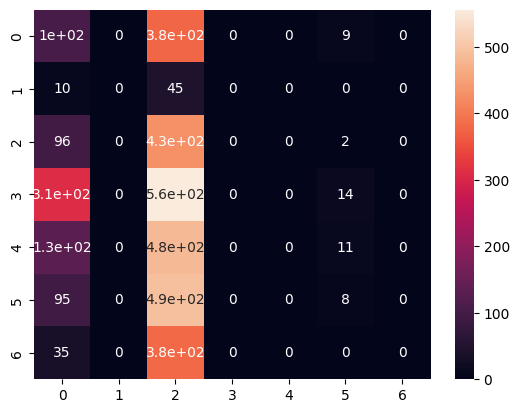

In [ ]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
# precision, recall(재현률), f1-score(F1점수) 등등을 계산해준다
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.13      0.21      0.17       491
           1       0.00      0.00      0.00        55
           2       0.16      0.81      0.26       528
           3       0.00      0.00      0.00       879
           4       0.00      0.00      0.00       626
           5       0.18      0.01      0.03       594
           6       0.00      0.00      0.00       416

    accuracy                           0.15      3589
   macro avg       0.07      0.15      0.06      3589
weighted avg       0.07      0.15      0.07      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 하나의 단일 이미지 클래스 분류하기
- 실제 사람 이미지를 불러와 감정을 분류해보자
  - 얼굴을 탐지하고 모델의 input에 맞춰 전처리를 해주자

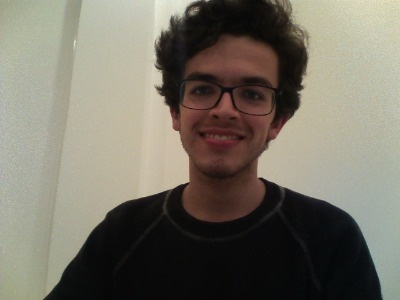

In [10]:
# 단일 이미지 분류에 사용될 이미지 불러오기
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/gabriel.png')
cv2_imshow(image)

In [11]:
# 감정 분류를 하기위해 이미지 전체를 넣는것이 아니라 얼굴만 넣으면 효과가 좋다
# 왜냐하면 얼빡샷 이미지로 학습을 했기 때문이다.
# 이전에 배웠던 얼굴 감지기를 사용한다.
image.shape
face_detector=cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Cascades/haarcascade_frontalface_default.xml')

In [12]:
# 얼굴 감지
original_image =image.copy()
faces=face_detector.detectMultiScale(original_image)

In [13]:
# 얼굴이 감지 되었으면 사각형을 반환한다
# 반환 값 array([[162,  40, 128, 128]], dtype=int32)
faces

array([[162,  40, 128, 128]], dtype=int32)

In [14]:
# 반환된 크기의 x,y,w,h를 활용하여 기본 관심 영역 이미지만 저장한다.
roi = image[40:40 +128, 162:162 + 128]

In [15]:
# 관심 영역 이미지만을 가져왔지만 분류기에 입력하기엔 인풋 사이즈가 안맞는다
roi.shape

(128, 128, 3)

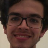

In [16]:
# resize를 활용하여 이미지의 크기를 맞춘다.
roi = cv2.resize(roi, (48,48))
cv2_imshow(roi)

In [17]:
# 학습한 데이터처럼 데이터 정규화를 한다.
roi = roi / 255
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [18]:
# expend_dims는 배열의 차원을 늘려준다 axis는 차원을 추가할 위치를 지정하는 것이다.
roi = np.expand_dims(roi,axis = 0)
roi.shape

(1, 48, 48, 3)

In [19]:
# 이미지 전처리가 완료되어 예측이 가능하다.
probs = network_loaded.predict(roi)
probs

1/1 [==============================] - 0s 319ms/step


array([[5.2841852e-04, 1.1444096e-06, 1.2489506e-03, 8.9390182e-01,
        1.0206469e-01, 2.1787030e-03, 7.6220960e-05]], dtype=float32)

In [20]:
result = np.argmax(probs)
result

3

In [21]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# 이미지안에 있는 여러 사람의 감정을 다 파악하기
- 얼굴감지를 통해 각각의 사람들의 얼굴 위치를 반환한다.

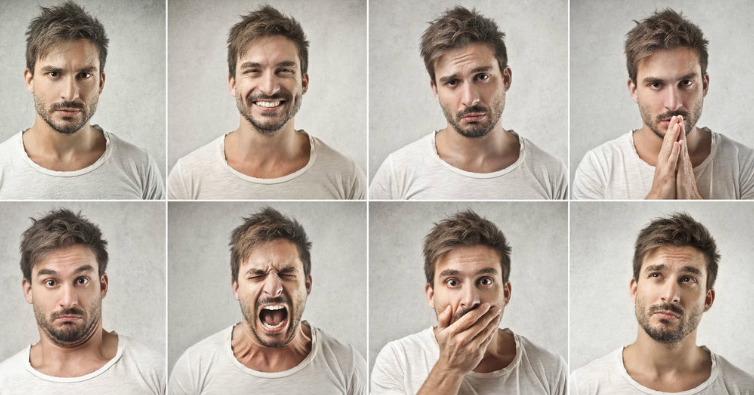

In [22]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/faces_emotions.png')
cv2_imshow(image)

In [23]:
# 한 이미지에 있는 모든 사람의 얼굴이 감지되어 배열로 반환
faces=face_detector.detectMultiScale(image)
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [24]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [25]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 49ms/step


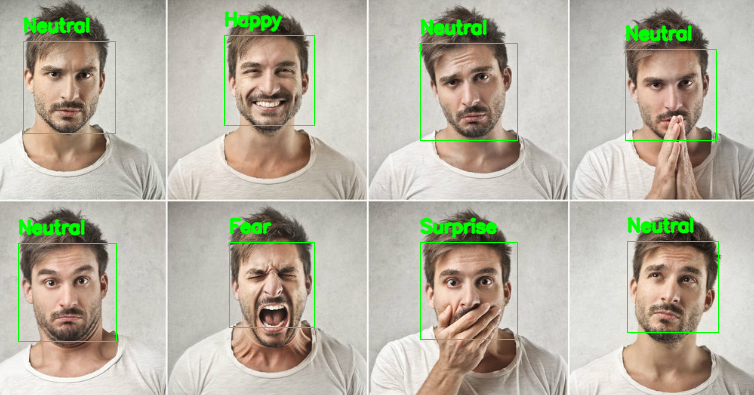

In [26]:
# 찾은 얼굴 배열들을 하나씩 순회하면서 전처리 및 감정 분류하여 원본 이미지에 표현

for (x,y,w,h) in faces:
  cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0),1)
  roi = image[y:y +h, x:x +w]
  roi = cv2.resize(roi, (48,48))
  roi = roi/255
  roi = np.expand_dims(roi, axis =0)
  prediction = network_loaded.predict(roi)
  cv2.putText(image, emotions[np.argmax(prediction)],(x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,255,0),2 ,cv2.LINE_AA)

cv2_imshow(image)

### 비디오에서 감정 분류하기
- 비디오를 프레임마다 캡처하여 캡처한 화면을 모델에 넣는다.

In [28]:
# cv2.videocapture()함수를 이용하여 비디오의 장면마다 캡쳐할 수 있다. (mp4파일)

cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Videos/emotion_test01.mp4')
connected, video = cap.read()
print(connected, video.shape)

True (360, 640, 3)


In [29]:
# drive에 저장하여 로컬환경이 아닌 cloud에 저장
#
save_path ='/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/Classification Emotions  with CNN/test.avi'
# avi 영상을 저장하기위한 코덱 설정
# fourcc.org에 정보 있
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# 초당 프레임, 낮을수록 영상이 느림
fps = 24
# 저장할 정보를 모은 객체 생성
# 4째 매개변수는 한 프레임마다 이미지의 크기이다 (640,360)
output_video = cv2.VideoWriter(save_path, fourcc,fps,(video.shape[1], video.shape[0]))

In [30]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()
  if not connected:
    break
  faces = face_detector.detectMultiScale(frame, scaleFactor =1.2, minNeighbors=5, minSize=(30,30))
  if len(faces) > 0:
    for (x,y,w,h) in faces:
      frame = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0),1)
      roi = frame[y:y +h, x:x +w]
      roi = cv2.resize(roi, (48,48))
      roi = roi/255
      roi = np.expand_dims(roi, axis = 0)
      prediction = network_loaded.predict(roi)

      if prediction is not None:
        result = np.argmax(prediction)
        cv2.putText(frame, emotions[np.argmax(prediction)],(x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,255,0),2 ,cv2.LINE_AA)

  cv2_imshow(frame)
  # 저장할 비디오객체에 프레임을 입력
  output_video.write(frame)

print('End')
# 모든 프레임 분석이 완료되었으면 비디오 저장
output_video.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.